In [28]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Activation,Input,CuDNNLSTM,CuDNNGRU, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.utils import to_categorical,plot_model
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model,Sequential
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.initializers import he_normal,Orthogonal
from keras.regularizers import l2
from keras.constraints import max_norm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import pickle
import seaborn as sns


Using TensorFlow backend.


In [0]:
from google.colab import files

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2019-09-10 03:05:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  13.0MB/s    in 1m 53s  

2019-09-10 03:07:33 (12.8 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [4]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [11]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sathvikchiramana","key":"2cc0ec64304b3258584f01e8be38e373"}'}

In [0]:
!pip install -q kaggle
'''!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json'''

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -p /content

 99% 270M/273M [00:07<00:00, 17.8MB/s]
100% 273M/273M [00:07<00:00, 37.0MB/s]
 75% 9.00M/12.0M [00:00<00:00, 17.7MB/s]
100% 12.0M/12.0M [00:00<00:00, 23.4MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 193MB/s]


# Reading data

In [4]:
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")


# Explorarory Data Analysis

In [5]:
print("Target column has", train['target'].isna().sum(), "missing values")
print("comment_text column has", train['comment_text'].isna().sum(), "missing values")

Target column has 0 missing values
comment_text column has 0 missing values


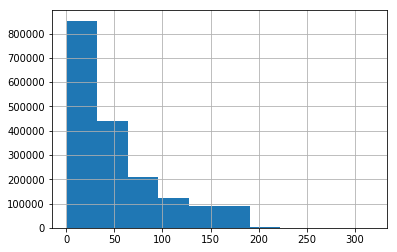

In [7]:
# see distribution of the comment_text length
train['comment_text'].apply(lambda x : len(str(x).split())).hist()

In [8]:
print("Mean value for the target column:  ", train["target"].mean())
print("Number of targets higher than 0.5: ", train[(train['target'] >0.5)]["target"].count())
print("Number of targets higher than 0.0: ", train[(train['target'] >0.0)]["target"].count())

Mean value for the target column:   0.10301729306264126
Number of targets higher than 0.5:  106438
Number of targets higher than 0.0:  540110


In [9]:
u_c = train['comment_text'].nunique()
print("Number of unique comments in train is ",u_c)

Number of unique comments in train is  1780823


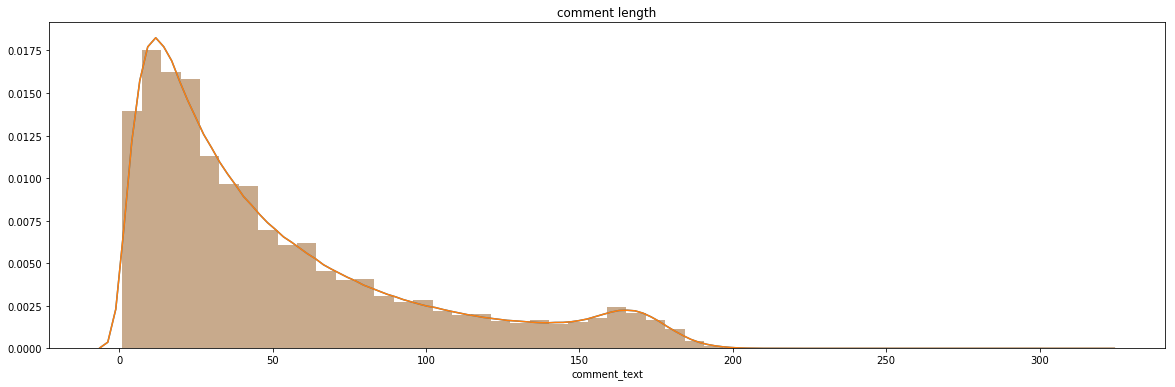

In [10]:
length=train['comment_text'].apply(lambda x : len(str(x).split()))
plt.figure(figsize=(20, 6))
plt.title('comment length')
sns.distplot(length)
sns.distplot(length)
plt.show()

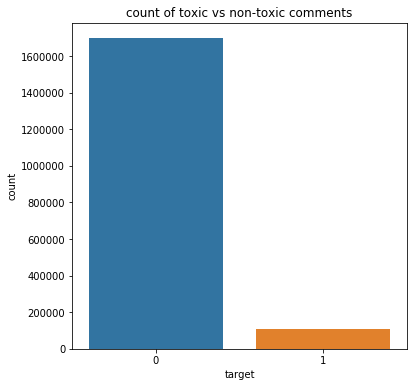

In [14]:
t_vs_nt= train['target'].apply(lambda x : 1 if (x > 0.5) else 0)
plt.figure(figsize=(6, 6))
sns.countplot(t_vs_nt)
plt.title("count of toxic vs non-toxic comments")
plt.show()

In [12]:
#for each identity we are finding number of toxic and nontoxic data points
idt = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']
labels = train.loc[:, ['target'] + idt ].dropna()
t = labels[labels['target'] >= .5][idt]
nt = labels[labels['target'] < .5][idt]
t_c = t.where(labels == 0, other = 1).sum()
nt_c = nt.where(labels == 0, other = 1).sum()

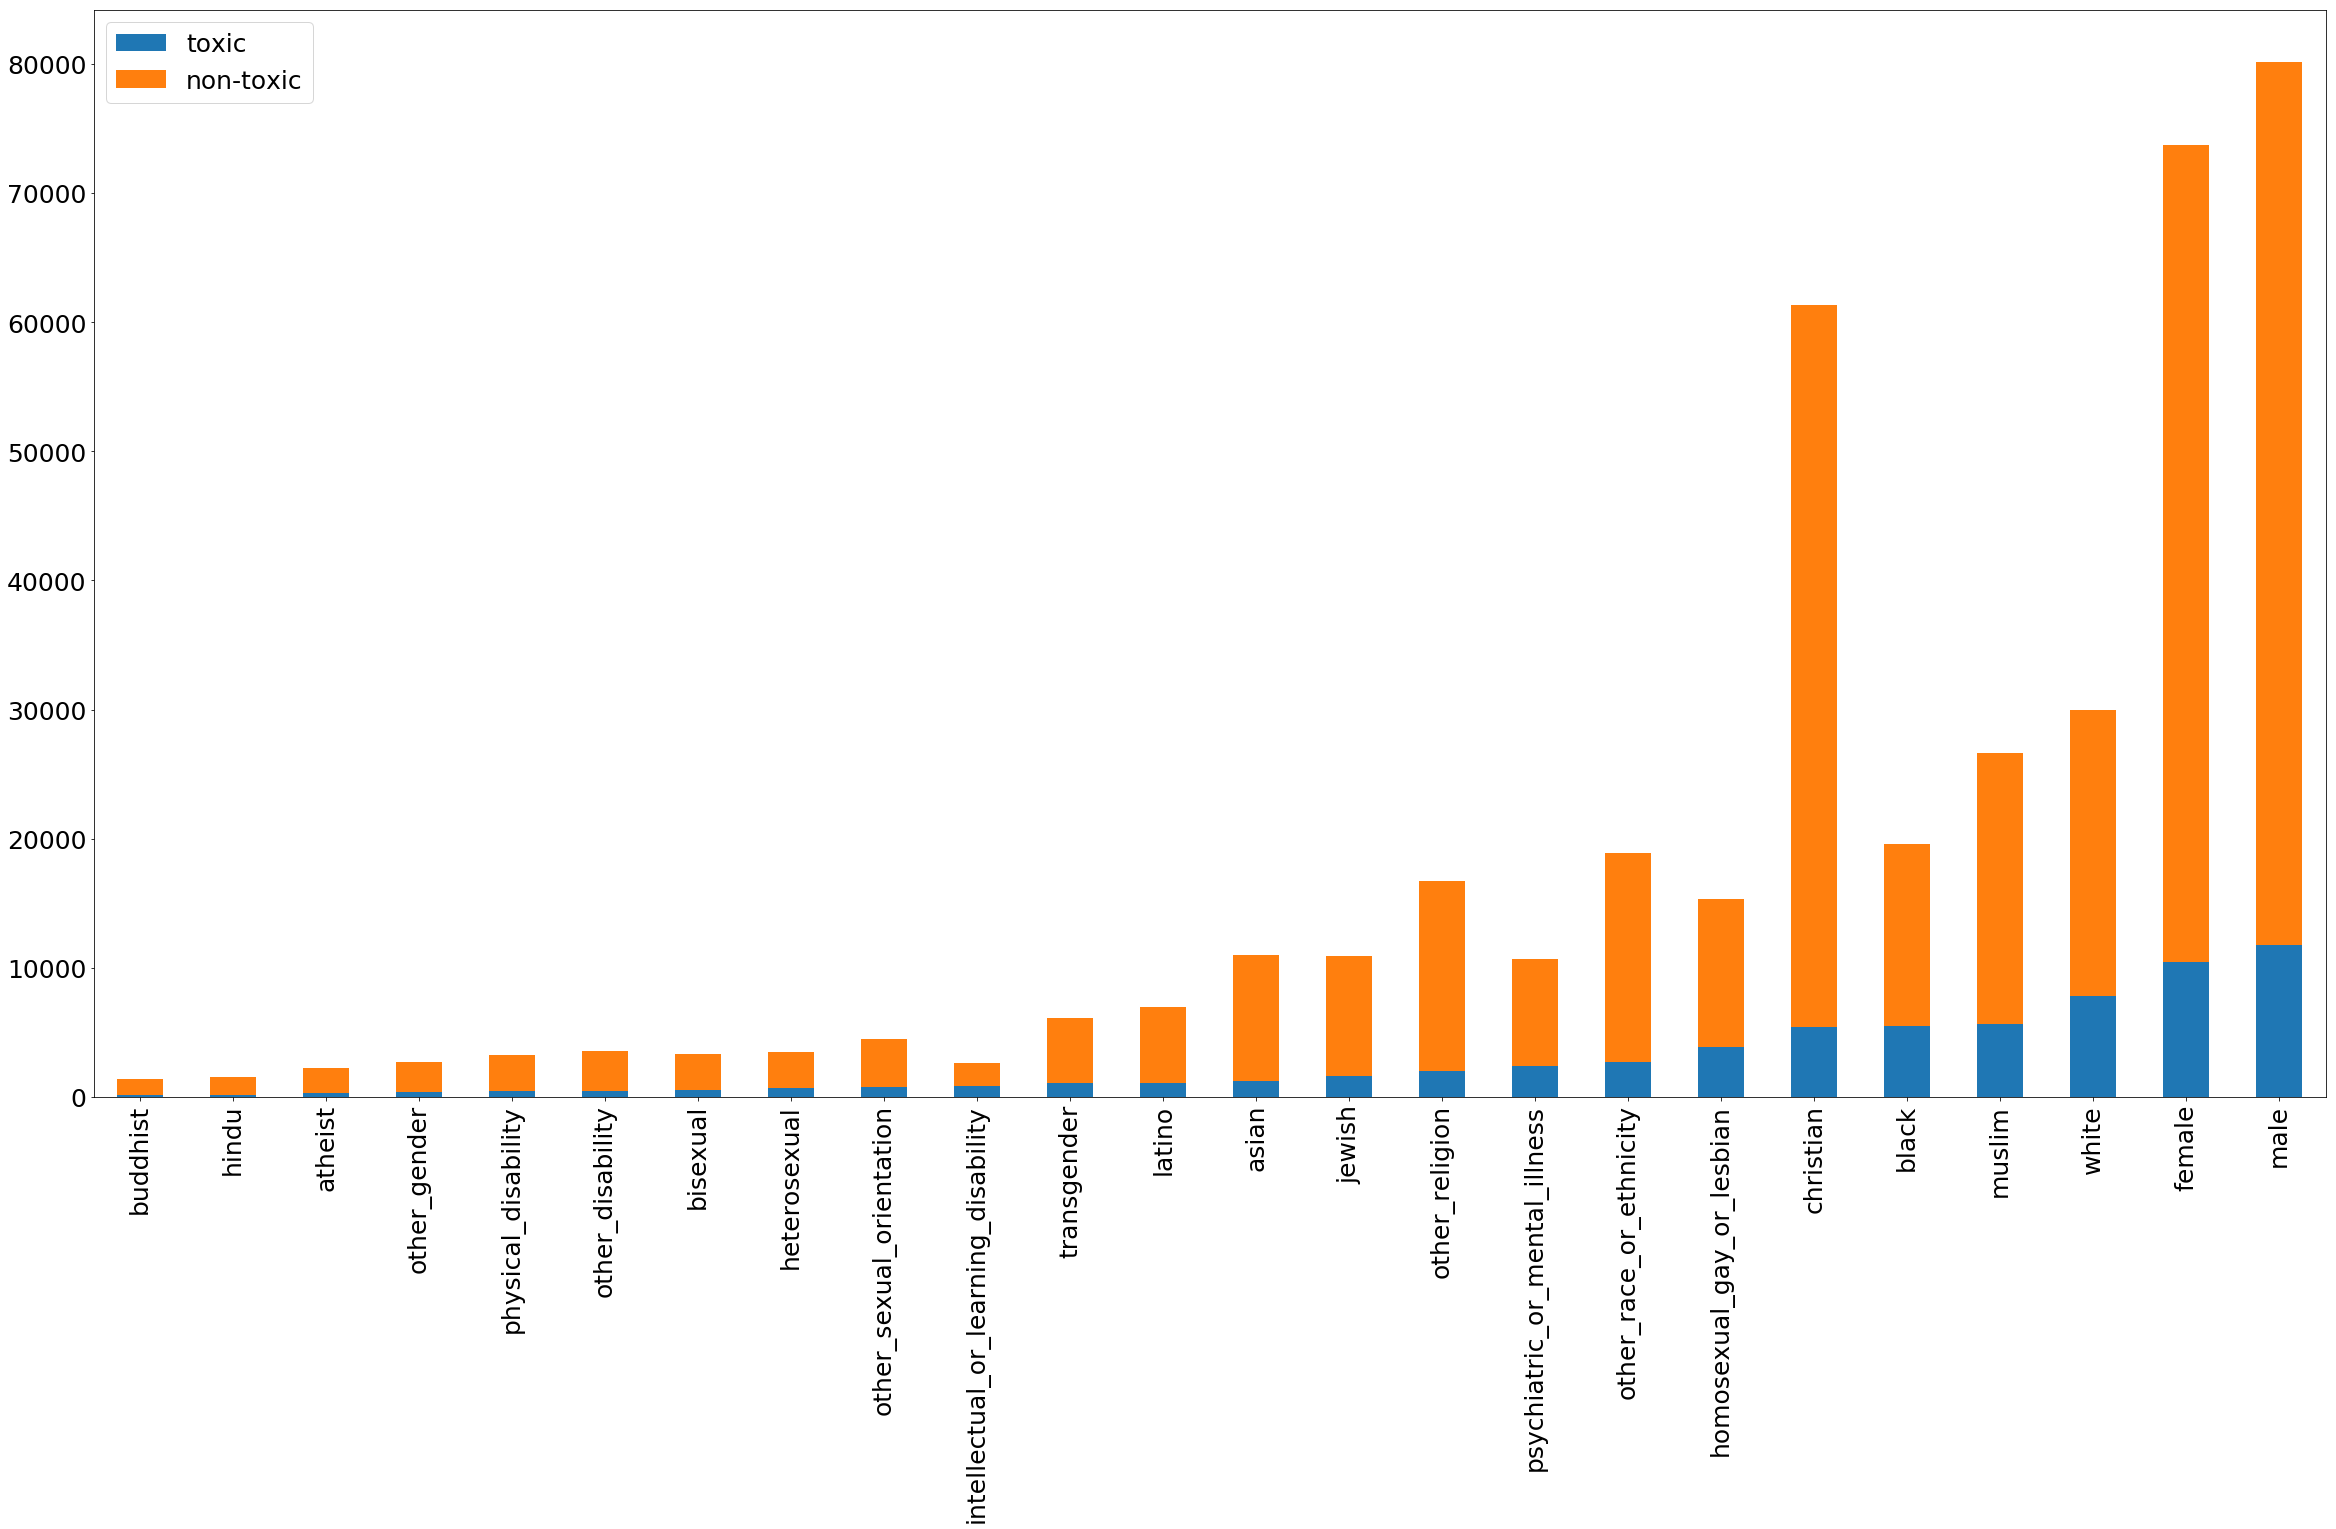

In [13]:
t_vs_nt = pd.concat([t_c, nt_c], axis=1)
t_vs_nt = t_vs_nt.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
t_vs_nt.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(40,20), fontsize=25).legend(prop={'size': 25})

# Preprocessing

In [16]:


def decontracted(phrase):

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
preprocessed_text = []
for sentance in tqdm(train['comment_text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.lower().strip())
train["clean_text"] = preprocessed_text

100%|██████████| 1804874/1804874 [03:40<00:00, 8192.29it/s]


In [17]:
preprocessed_comments_test = []
for sentence in tqdm(test['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_comments_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:11<00:00, 8188.85it/s]


In [0]:
test['comment_text'] = preprocessed_comments_test

In [0]:
train_len = len(train.index)

In [0]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [0]:
for column in identity_columns + ['target']:
    train[column] = np.where(train[column] >= 0.5, True, False)

In [0]:
y = train['target'].values

### spliting data into train and test set

In [24]:

from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(train,y,test_size=0.30,random_state=43)

print(x_train.shape)
print(x_cv.shape)

(1263411, 46)
(541463, 46)


In [0]:
max_vocab = 100000
max_seq_length = 300

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train[TEXT_COLUMN])

def padding_text(texts, tokenizer):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_seq_length)
train_text = padding_text(x_train['comment_text'], tokenizer)
train_y = to_categorical(x_train['target'])
validate_text = padding_text(x_cv['comment_text'], tokenizer)
validate_y = to_categorical(x_cv['target'])
test_text = padding_text(test['comment_text'], tokenizer)

#### Glove vectors is giving very low auc so we are using crawl-300d-2M

In [26]:
embeddings_index = {}
with open('crawl-300d-2M.vec' ,encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print(len(tokenizer.word_index))

397708

In [0]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,300))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    num_words_in_embedding += 1
    embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix.shape

(397709, 300)

In [30]:
input_text= Input(shape=(max_seq_length,), dtype='float32')
embedding = Embedding(len(tokenizer.word_index) + 1, 300,weights=[embedding_matrix],input_length=max_seq_length,trainable=False)
x = embedding(input_text)
# SpatialDropout1D drops entire 1D feature maps instead of individual elements
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Conv1D(128, kernel_size =3, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_p = GlobalAveragePooling1D()(x)
max_p = GlobalMaxPooling1D()(x)
x = concatenate([avg_p, max_p])
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_text], outputs=[output])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
from sklearn.metrics import roc_auc_score


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[auroc])


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [33]:
history = model.fit(train_text,train_y,
              batch_size=1024,
              epochs=15,
              validation_data=(validate_text, validate_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1263411 samples, validate on 541463 samples
Epoch 1/15
1263411/1263411 [==============================] - 584s 463us/step - loss: 0.1583 - auroc: 0.9191 - val_loss: 0.1291 - val_auroc: 0.9544
Epoch 2/15
1263411/1263411 [==============================] - 579s 458us/step - loss: 0.1367 - auroc: 0.9485 - val_loss: 0.1291 - val_auroc: 0.9582
Epoch 3/15
1263411/1263411 [==============================] - 580s 459us/step - loss: 0.1307 - auroc: 0.9532 - val_loss: 0.1215 - val_auroc: 0.9603
Epoch 4/15
1263411/1263411 [==============================] - 581s 460us/step - loss: 0.1277 - auroc: 0.9559 - val_loss: 0.1218 - val_auroc: 0.9611
Epoch 5/15
1263411/1263411 [==============================] - 581s 460us/step - loss: 0.1254 - auroc: 0.9577 - val_loss: 0.1195 - val_auroc: 0.9619
Epoch 6/15
1263411/1263411 [==============================] - 578s 458us/step - loss: 0.1238 - auroc: 0.9591 - va

In [0]:
predictions = model.predict(test_text)[:, 1]

In [35]:
test.head(5)

,id,comment_text
0,7097320,integrity means pay debts does apply president...
1,7097321,this malfeasance administrator board they wast...
2,7097322,rmiller101 spoken like true elitist but look b...
3,7097323,paul thank kind words i indeed strong beliefs ...
4,7097324,sorry missed high school eisenhower sent troop...


In [15]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)

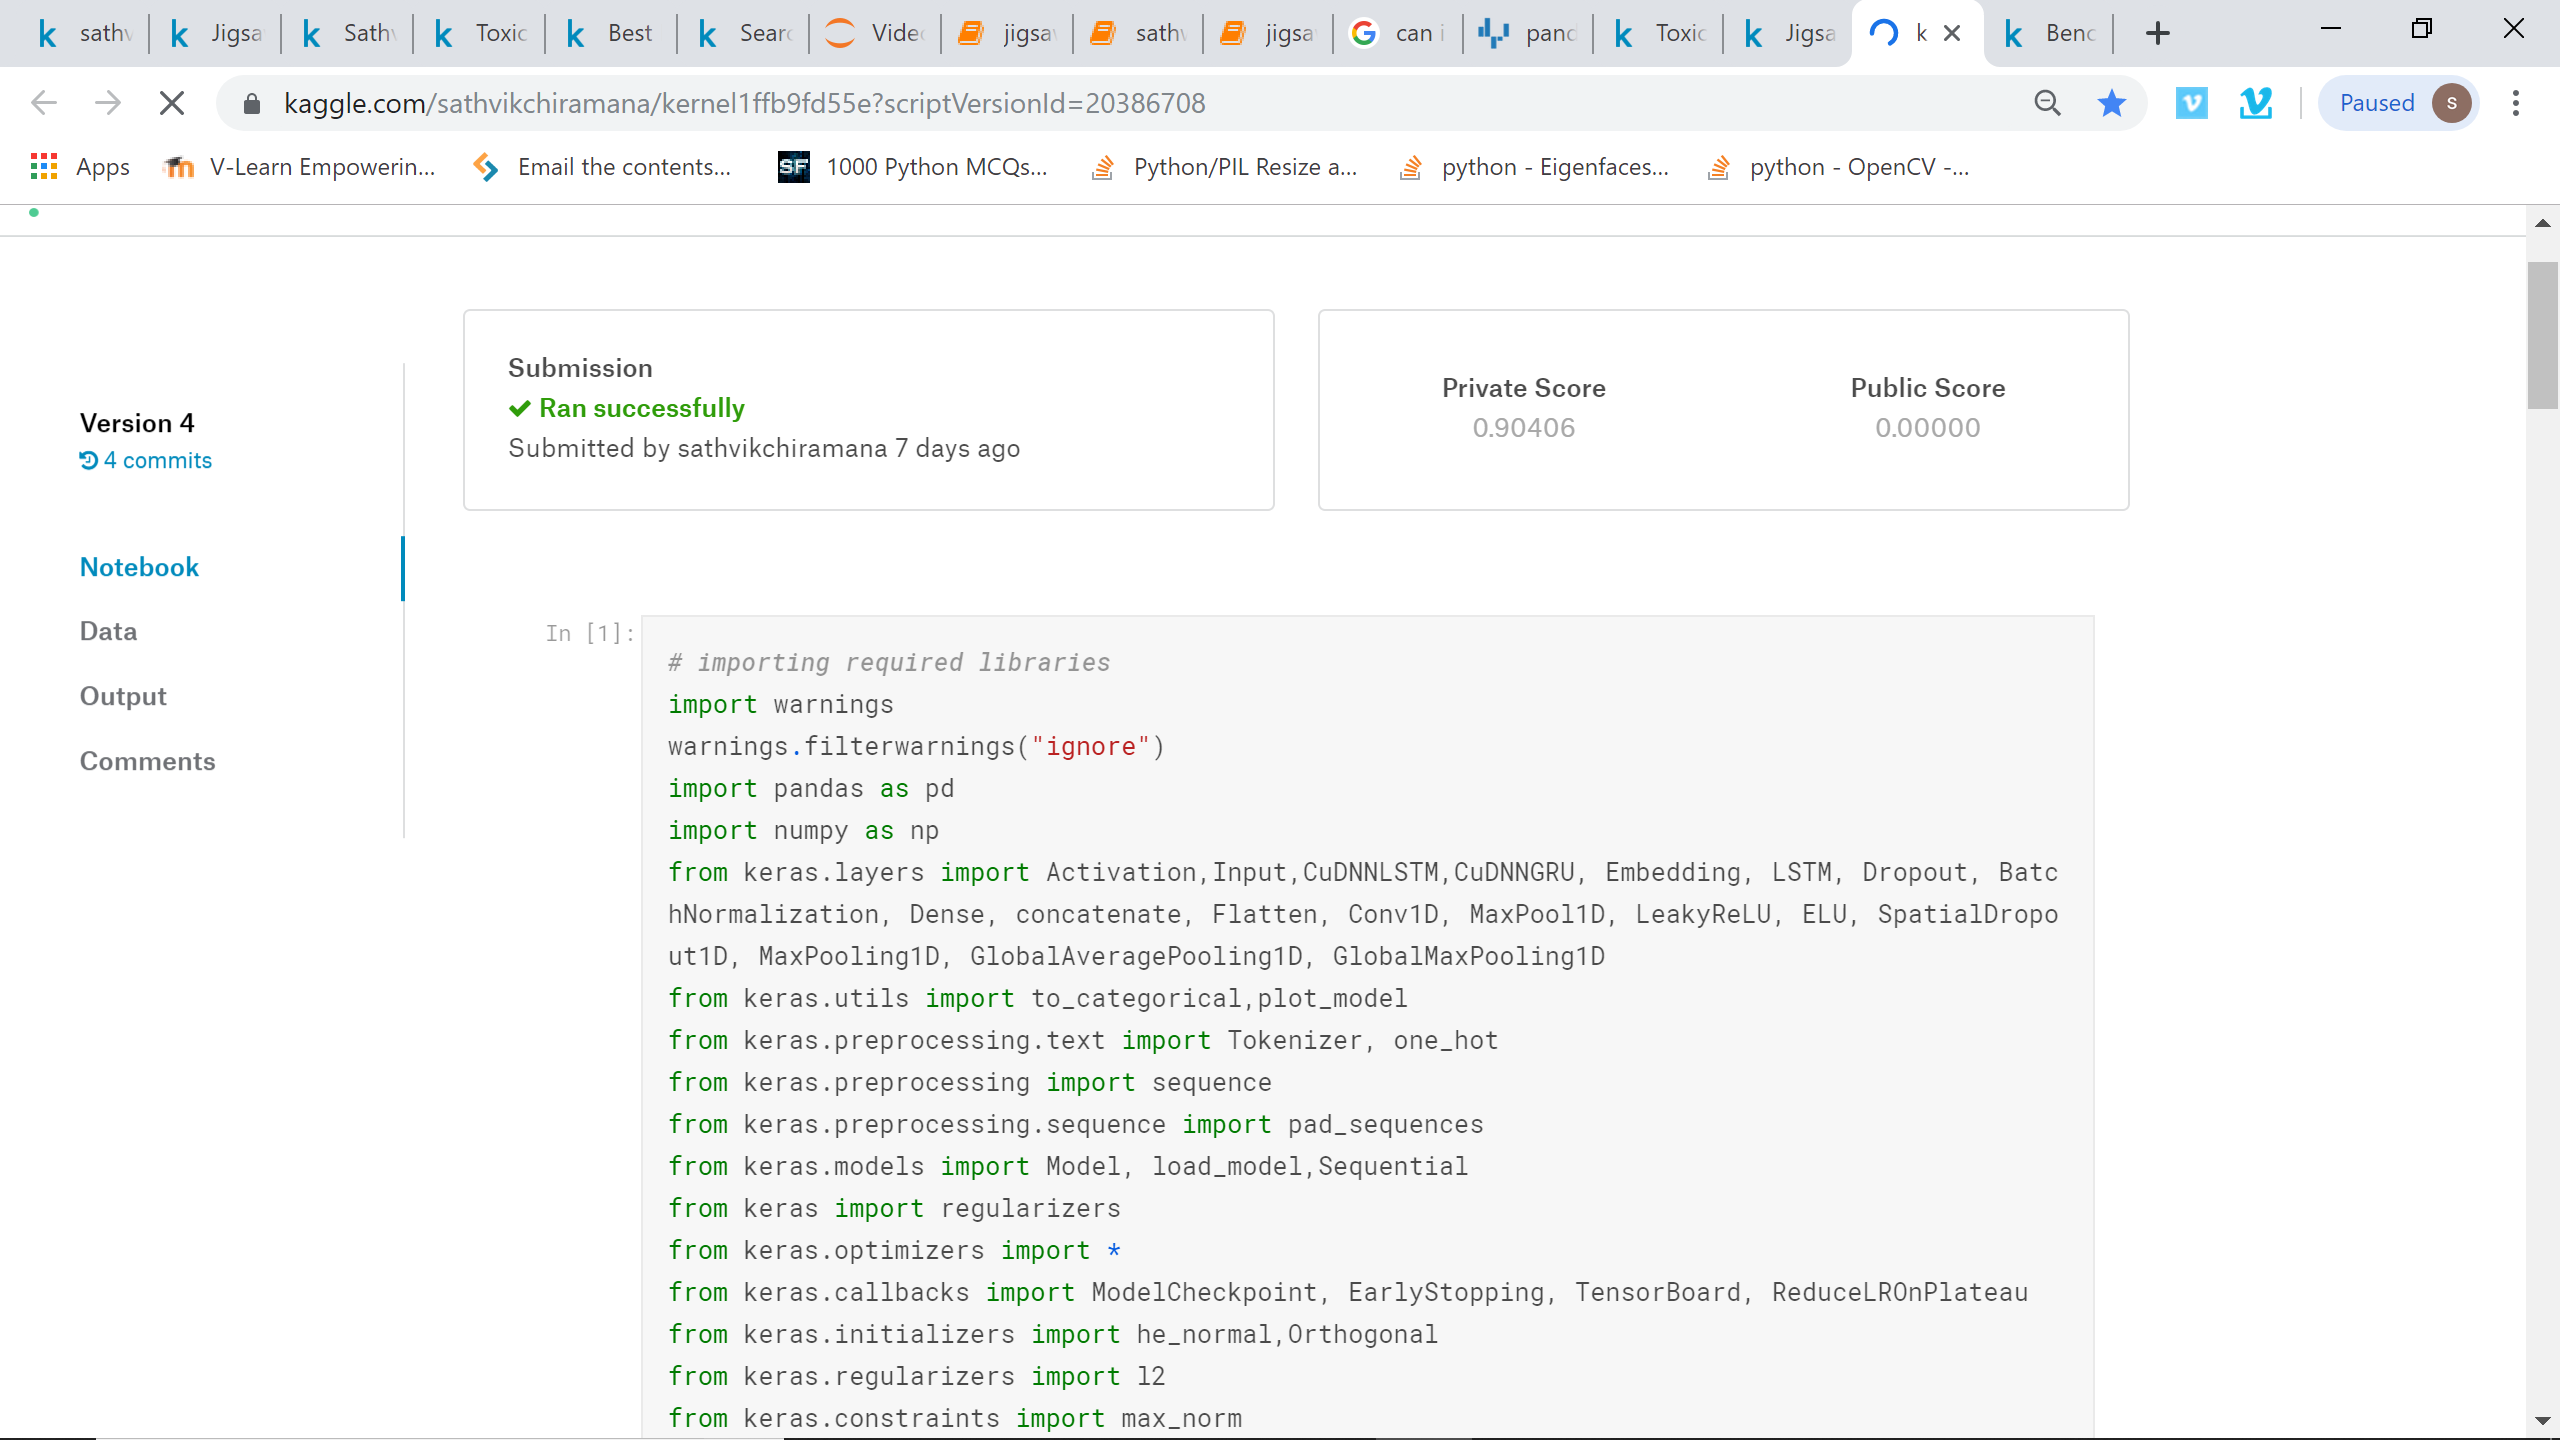

In [18]:
from IPython.display import Image
Image(filename='jigsaw1.png')

With the above deep learning model and with crawl embedding vectors we managed to get a auc of 0.90 it is good but not 
very good so we will use a state of the art bert models for embedding and classification

# Bert Model

i refered this brillant tutorial to get an understanding of bert models

https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [15]:
train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import torch.utils.data
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import warnings
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from pytorch_pretrained_bert import BertConfig

warnings.filterwarnings(action='once')

device = torch.device('cuda') #This helps our model to run on cuda gpu's

In [4]:
max_seq_length = 300 
seed = 1100 #it is used to retain the state of system
epochs = 1 #single epoch itself takes very huge amount of time but it gives very good auc value
train_size=1000000                         
valid_size= 100000
TOXICITY_COLUMN = 'target'

In [5]:
from pytorch_pretrained_bert import convert_tf_checkpoint_to_pytorch
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification,BertAdam
BERT_MODEL_PATH = '../input/bert-pretrained-models/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12/'
#to convert tensorflow check points to pytorch checkpoints we use the following code snippet and we are taking
#.ckpt file and .json file and we are placing them in pytorch_model.bin file
convert_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(BERT_MODEL_PATH + 'bert_model.ckpt',BERT_MODEL_PATH + 'bert_config.json',"../working/" + 'pytorch_model.bin')
shutil.copyfile(BERT_MODEL_PATH + 'bert_config.json', "../working/" + 'bert_config.json')

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5506: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216

Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

Converting TensorFlow checkpoint from /kaggle/input/bert-pretrained-models/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape [30522, 768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_0/attention/output/L

Loading TF weight bert/encoder/layer_3/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_3/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_3/output/dense/kernel with shape [3072, 768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_4/attention/self/key/bias with shape [768]
Loading TF weight bert/encoder/layer_4/attention/self/key/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_4/attention/self/query/bias with shape [768]
Loading TF weight bert/encoder/layer_4/attention/self/query/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_4/attention/self/value/bias with shape

'../working/bert_config.json'

In [6]:
from pytorch_pretrained_bert import BertConfig

bert_config = BertConfig('../input/bert-pretrained-models/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12/'+'bert_config.json')

In [10]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2 #we are subtracting it by 2 because we are adding 2 extra tokens [cls],[sep]
    tokens = []
    longer = 0
    for text in example:
        tokens_a = tokenizer.tokenize(text) #This line breaks the text into bert tokens
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length] #If number of tokens is more than max_seq_length we slice the extra tokens
            longer += 1
        #every list of tokens should start with [cls] and stop with [sep] before converting each token to ids
        #so we are appending [cls] and [sep] to list of tokens and  length of the lists of tokens should be same
        #so we are padding with 0's and then passing to convert_tokens_to_ids function
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        tokens.append(one_token)
    return np.array(tokens)

In [18]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, cache_dir=None,do_lower_case=True)
train_sample = pd.read_csv(os.path.join("../input/jigsaw-unintended-bias-in-toxicity-classification/","train.csv")).sample(num_to_load+valid_size,random_state=seed)

train_sample['comment_text'] = train_sample['comment_text'].astype(str) 

sequences = convert_lines(train_sample["comment_text"].fillna("DUMMY_VALUE"),max_seq_length,tokenizer)

identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white', 'psychiatric_or_mental_illness']
y_columns=['target']

train_sample = train_sample.drop(['comment_text'],axis=1)

train_sample['target']=(train_sample['target']>=0.5).astype(float)

In [19]:
test_df=train_sample.tail(valid_size).copy()
train_sample=train_sample.head(num_to_load)

In [20]:
X = sequences[:num_to_load]                
y = train_df[y_columns].values[:num_to_load]

In [21]:
#before importing the data we are converting the data into tensors and then import the dataset
train = torch.utils.data.TensorDataset(torch.tensor(X,dtype=torch.long), torch.tensor(y,dtype=torch.float))

In [22]:
batch_size = 32
acc_steps=2
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = BertForSequenceClassification.from_pretrained("../working",cache_dir=None,num_labels=len(y_columns))
model.zero_grad() # we are resetting all the gradients to zero
model = model.to(device) #used to run our model on cuda 
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

train_steps = int(epochs*len(train)/batch_size/acc_steps)
#bertAdam optimizer is state of the art optimizer so we are using it
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-4,warmup=0.05,t_total=train_steps)
#amp is used to speed up the training process on nvidia gpu's
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)
model=model.train()

tq = range(epochs)
for epoch in tq:
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    avg_loss = 0.
    avg_accuracy = 0.
    lossf=None
    tk0 = enumerate(train_loader)
    optimizer.zero_grad()  
    for i,(x_batch, y_batch) in tk0:
        y_pred = model(x_batch.to(device), attention_mask=(x_batch>0).to(device), labels=None)
        #the loss that we are using here is binary_cross_entropy_with_logits
        loss =  F.binary_cross_entropy_with_logits(y_pred,y_batch.to(device))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        if (i+1) % acc_steps == 0:             
            optimizer.step()                            
            optimizer.zero_grad()
        if lossf:
            lossf = 0.98*lossf+0.02*loss.item()
        else:
            lossf = loss.item()
        tk0.set_postfix(loss = lossf)
        avg_loss += loss.item() / len(train_loader) #used to find avg loss acquired by each of the item
        avg_accuracy += torch.mean(((torch.sigmoid(y_pred[:,0])>0.5) == (y_batch[:,0]>0.5).to(device)).to(torch.float) ).item()/len(train_loader)
    tq.set_postfix(avg_loss=avg_loss,avg_accuracy=avg_accuracy)

#We are saving our model
torch.save(model.state_dict(), "bert_pytorch.bin")

In [5]:
max_seq_length = 300
seed = 1100
BATCH_SIZE = 32
BERT_MODEL_PATH = '../input/bert-pretrained-models/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12/'

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

bert_config = BertConfig('../input/pytorch/bert_config.json')
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, cache_dir=None,do_lower_case=True)

In [27]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2 
    tokens = []
    longer = 0
    for text in tqdm(example):
        tokens_a = tokenizer.tokenize(text) 
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length] 
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        tokens.append(one_token)
    return np.array(tokens)

In [6]:
test_df = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
test_df['comment_text'] = test_df['comment_text'].astype(str) 
X_test = convert_lines(test_df["comment_text"].fillna("DUMMY_VALUE"), max_seq_length, tokenizer)

100%|██████████| 97320/97320 [01:56<00:00, 831.89it/s]


In [7]:
model = BertForSequenceClassification(bert_config, num_labels=1)
#loading the trained model
model.load_state_dict(torch.load("../input/pytorch/bert_pytorch.bin"))
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [12]:
test_preds = np.zeros((len(X_test)))
test = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)
tk0 = tqdm(test_loader)
for i, (x_batch,) in enumerate(tk0):
    pred = model(x_batch.to(device), attention_mask=(x_batch > 0).to(device), labels=None)
    test_preds[i * 32:(i + 1) * 32] = pred[:, 0].detach().cpu().squeeze().numpy()

test_pred = torch.sigmoid(torch.tensor(test_preds)).numpy().ravel()

100%|██████████| 3042/3042 [11:15<00:00,  4.51it/s]


In [23]:
submission = pd.DataFrame.from_dict({
    'id': test_df['id'],
    'prediction': test_pred
})
submission.to_csv('submission.csv', index=False)

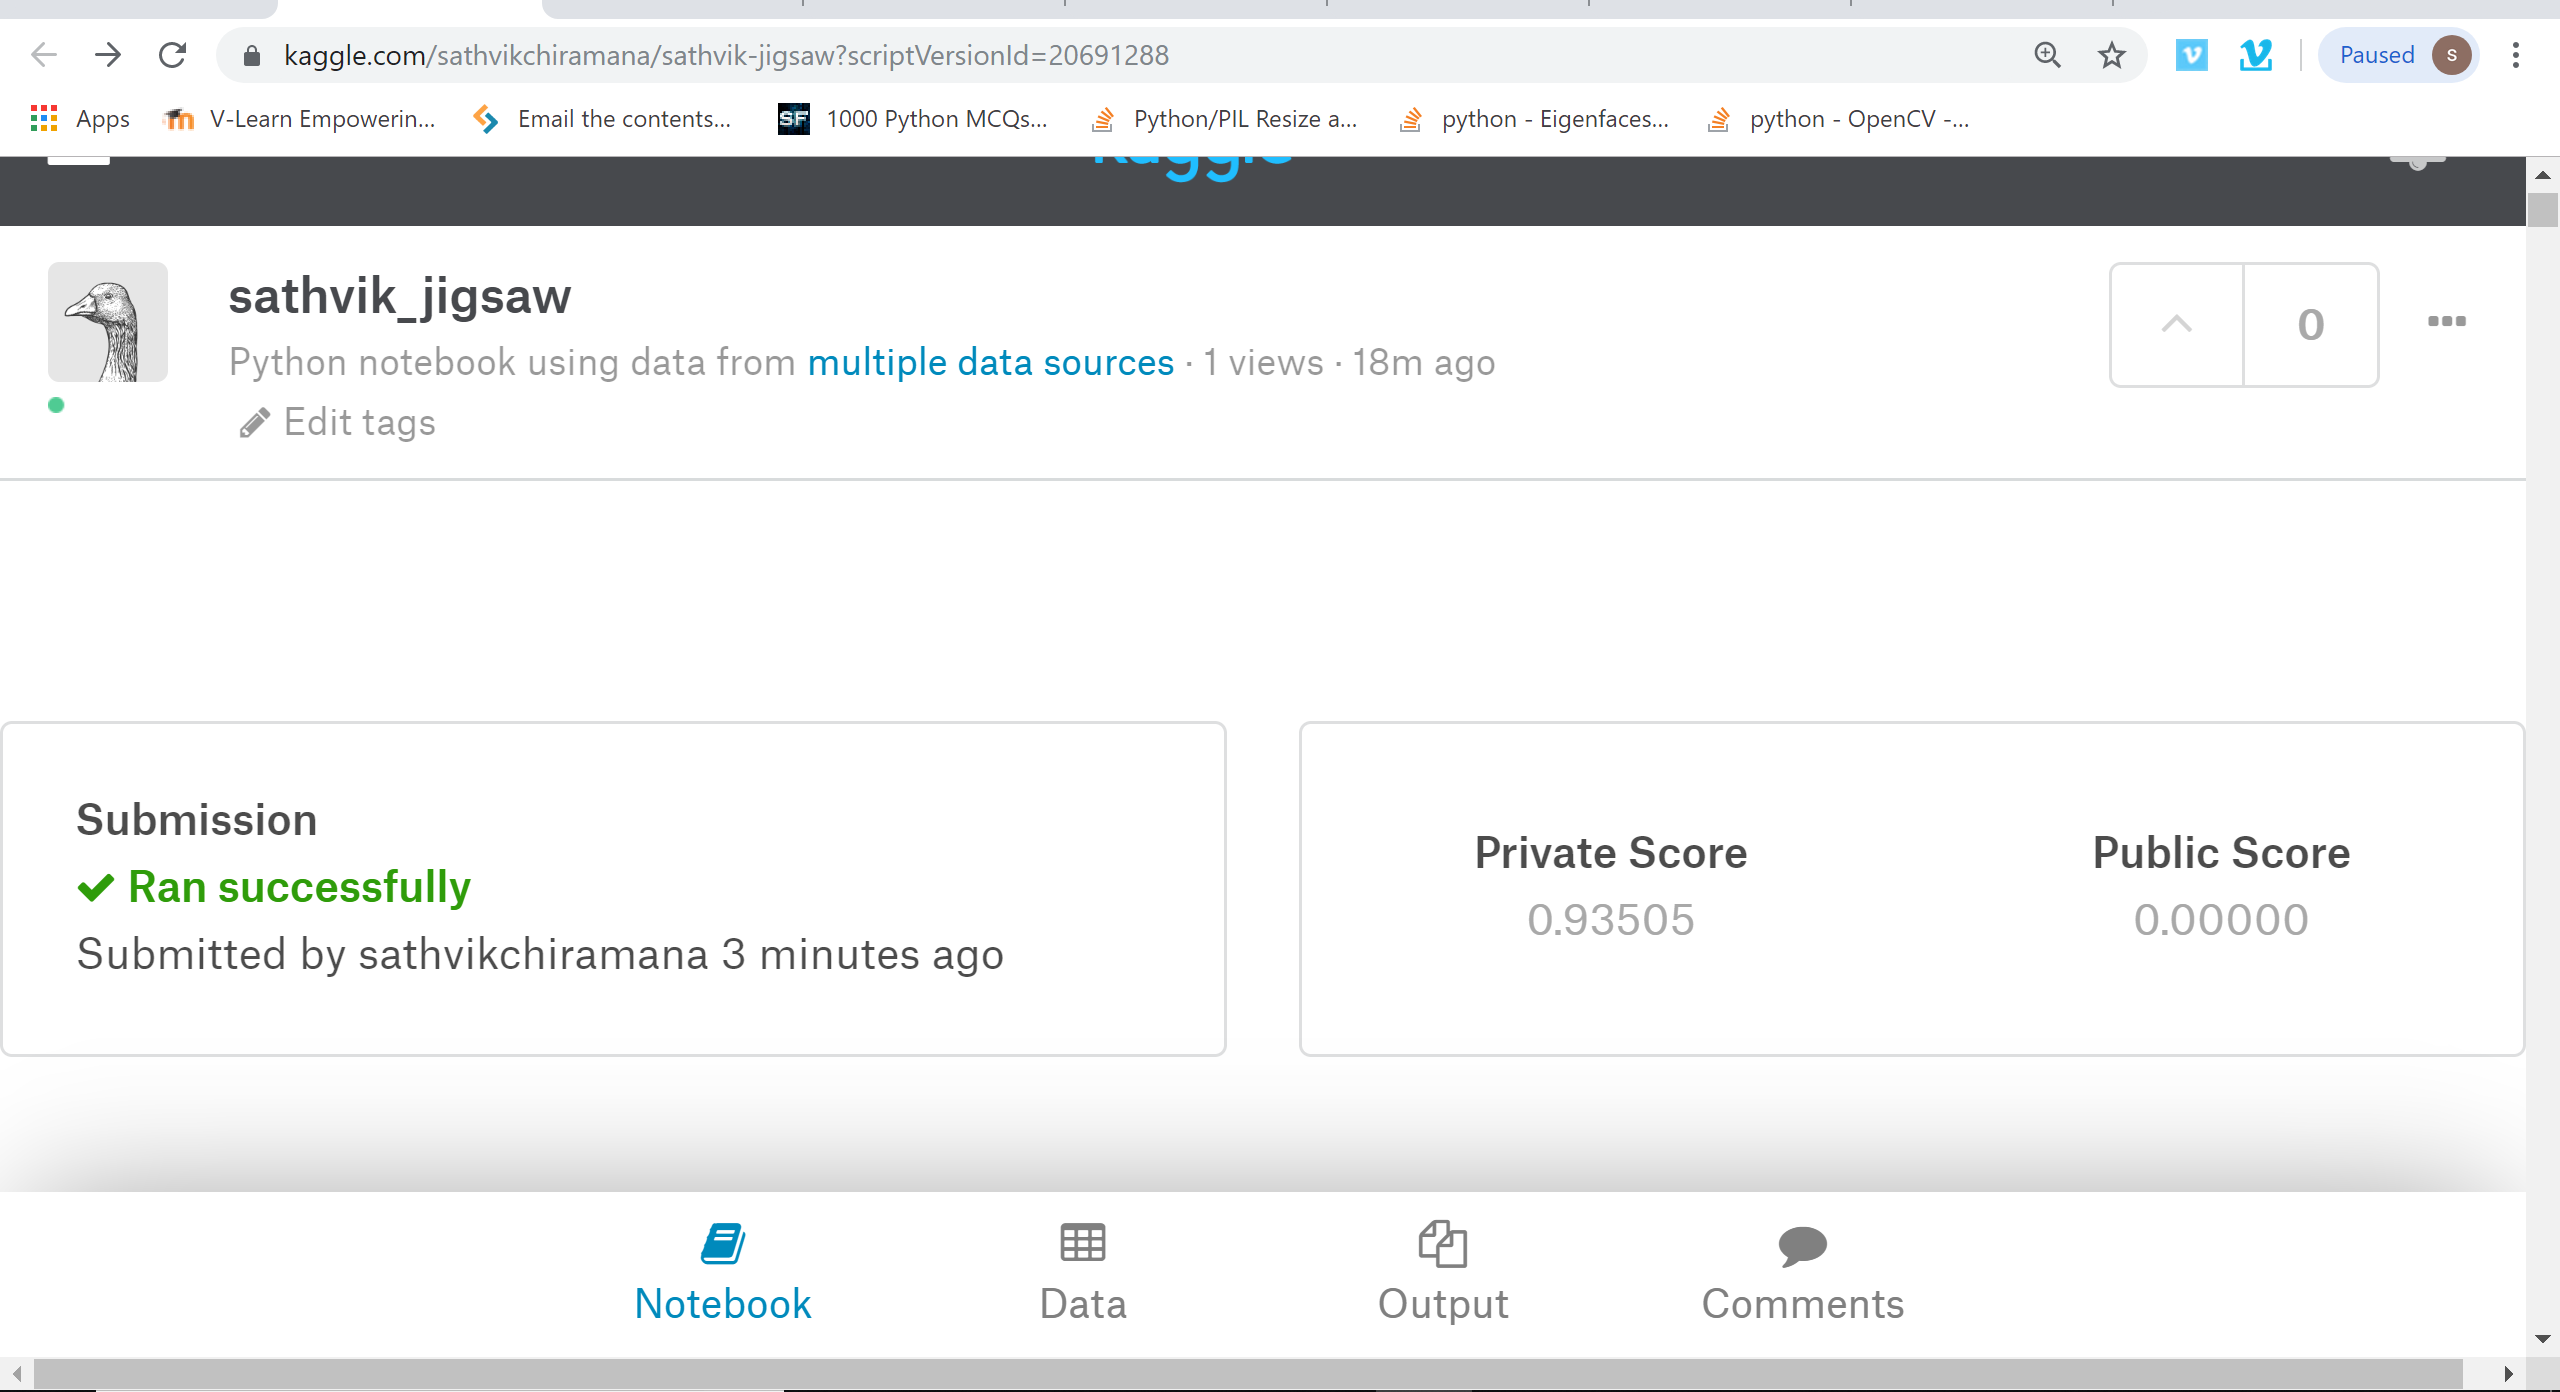

In [26]:
from IPython.display import Image
Image(filename='jigsaw2.png')

### Conclusion

We can clearly see that our bert model is giving us the score of 0.935 which is really good
where as our first model has given us only 0.90